<a href="https://colab.research.google.com/github/jedcheng/micromagnetic_std_problem4/blob/main/std_problem4_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from numba import jit, njit, prange
from torch.fft import fftn, ifftn
import time
import torch
import math






@jit(nopython=True, parallel=True)
def calcDemagTensor(nx, ny, nz, dd, Kxx, Kxy, Kxz, Kyy, Kyz, Kzz, prefactor):
    for K in prange(-nz + 1, nz):
        for J in prange(-ny + 1, ny):
            for I in prange(-nx + 1, nx):
                if I == 0 and J == 0 and K == 0:
                    continue
                L = I + nx
                M = J + ny
                N = K + nz
                for i in range(2):
                    for j in range(2):
                        for k in range(2):
                            r = math.sqrt((I + i - 0.5) * (I + i - 0.5) * dd * dd + (J + j - 0.5) * (J + j - 0.5) * dd * dd + (K + k - 0.5) * (K + k - 0.5) * dd * dd)
                            Kxx[L, M, N] += (-1) ** (i + j + k) * math.atan((K + k - 0.5) * (J + j - 0.5) * dd / r / (I + i - 0.5))
                            Kxy[L, M, N] += (-1) ** (i + j + k) * math.log((K + k - 0.5) * dd + r)
                            Kxz[L, M, N] += (-1) ** (i + j + k) * math.log((J + j - 0.5) * dd + r)
                            Kyy[L, M, N] += (-1) ** (i + j + k) * math.atan((I + i - 0.5) * (K + k - 0.5) * dd / r / (J + j - 0.5))
                            Kyz[L, M, N] += (-1) ** (i + j + k) * math.log((I + i - 0.5) * dd + r)
                            Kzz[L, M, N] += (-1) ** (i + j + k) * math.atan((J + j - 0.5) * (I + i - 0.5) * dd / r / (K + k - 0.5))
                Kxx[L, M, N] *= prefactor
                Kxy[L, M, N] *= -prefactor
                Kxz[L, M, N] *= -prefactor
                Kyy[L, M, N] *= prefactor
                Kyz[L, M, N] *= -prefactor
                Kzz[L, M, N] *= prefactor

    return Kxx, Kxy, Kxz, Kyy, Kyz, Kzz



In [2]:
data_type = torch.float32
saving_step = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def time_function(t, dt, Hx, Hy, Hz, alpha, prefactor1, prefactor2):
    # time function
    # apply this to get into the s-state
    if t < 4000:
        Hx += 100
        Hy += 100
        Hz += 100

    # reduced the field to 0
    elif t < 6000:
        Hx += (6000 - t)/20
        Hy += (6000 - t)/20
        Hz += (6000 - t)/20



    # start applying the field for the standard problem 4a
    elif t > 50000:
        Hx -= 19.576
        Hy += 3.422
        alpha = 0.02
        prefactor1 = (-0.221) * dt / (1 + alpha**2)
        prefactor2 = prefactor1 * alpha /Ms


    return Hx, Hy, Hz, alpha, prefactor1, prefactor2

In [4]:


nx = 166  # number of cells on x direction
ny = 42
nz = 1
dd = 3  # cell volume = dd x dd x dd
dt = 5E-6  # timestep in nanoseconds

timesteps = 250000
alpha = 0.5  # damping constant to relax system to S-state
exchConstant = 1.3E-11 * 1E18  # nanometer/nanosecond units

mu_0 = 1.256636  # vacuum permeability, = 4 * pi / 10
Ms = 800  # saturation magnetization
exch = 2 * exchConstant / mu_0 / Ms / Ms
prefactor1 = (-0.221) * dt / (1 + alpha * alpha)
prefactor2 = prefactor1 * alpha / Ms

Mx = torch.full((nx, ny, nz), Ms, dtype=data_type, device=device)  # magnetization on x direction
My = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # magnetization on y direction
Mz = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # magnetization on z direction

deltaMx = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # change of magnetization on x direction
deltaMy = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # change of magnetization on y direction
deltaMz = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # change of magnetization on z direction
mag = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # magnitude of magnetization


Kxx = np.zeros((nx * 2, ny * 2, nz * 2), dtype=np.float32)  # Initialization of demagnetization tensor
Kxy = np.zeros((nx * 2, ny * 2, nz * 2), dtype=np.float32)
Kxz = np.zeros((nx * 2, ny * 2, nz * 2), dtype=np.float32)
Kyy = np.zeros((nx * 2, ny * 2, nz * 2), dtype=np.float32)
Kyz = np.zeros((nx * 2, ny * 2, nz * 2), dtype=np.float32)
Kzz = np.zeros((nx * 2, ny * 2, nz * 2), dtype=np.float32)
prefactor = 1 / (4 * torch.pi)





In [5]:
Kxx, Kxy, Kxz, Kyy, Kyz, Kzz = calcDemagTensor(nx, ny, nz, dd, Kxx, Kxy, Kxz, Kyy, Kyz, Kzz, prefactor)

Kxx = torch.from_numpy(Kxx).float().to(device)
Kxy = torch.from_numpy(Kxy).float().to(device)
Kxz = torch.from_numpy(Kxz).float().to(device)
Kyy = torch.from_numpy(Kyy).float().to(device)
Kyz = torch.from_numpy(Kyz).float().to(device)
Kzz = torch.from_numpy(Kzz).float().to(device)

In [6]:
Kxx_fft = fftn(Kxx)  # fast fourier transform of demag tensor
Kxy_fft = fftn(Kxy)
Kxz_fft = fftn(Kxz)
Kyy_fft = fftn(Kyy)
Kyz_fft = fftn(Kyz)
Kzz_fft = fftn(Kzz)

Hx_exch = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # exchange field on x direction
Hy_exch = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # exchange field on y direction
Hz_exch = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # exchange field on z direction


Hx0 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hx1 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hx2 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hx3 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)

Hy0 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hy1 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hy2 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hy3 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)

Hz0 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hz1 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hz2 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hz3 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)

t_array = torch.zeros(int(timesteps/saving_step))
Mx_mean_array = torch.zeros(int(timesteps/saving_step))
My_mean_array = torch.zeros(int(timesteps/saving_step))
Mz_mean_array = torch.zeros(int(timesteps/saving_step))
t_taken_array = torch.zeros(int(timesteps/saving_step))

In [7]:
start_time = time.time()
print_start_time = time.time()
for t in range(timesteps):

    Mx = torch.nn.functional.pad(Mx, pad=(0, nz, 0, ny, 0, nx), mode='constant', value=0)
    My = torch.nn.functional.pad(My, pad=(0, nz, 0, ny, 0, nx), mode='constant', value=0)
    Mz = torch.nn.functional.pad(Mz, pad=(0, nz, 0, ny, 0, nx), mode='constant', value=0)

    Mx_FFT = fftn(Mx)
    My_FFT = fftn(My)
    Mz_FFT = fftn(Mz)

    Hx = ifftn(Mx_FFT * Kxx_fft + My_FFT * Kxy_fft + Mz_FFT * Kxz_fft)  # calc demag field with fft
    Hy = ifftn(Mx_FFT * Kxy_fft + My_FFT * Kyy_fft + Mz_FFT * Kyz_fft)
    Hz = ifftn(Mx_FFT * Kxz_fft + My_FFT * Kyz_fft + Mz_FFT * Kzz_fft)

    Hx = torch.real(Hx[nx:(2 * nx), ny:(2 * ny), nz:(2 * nz)])  # truncation of demag field
    Hy = torch.real(Hy[nx:(2 * nx), ny:(2 * ny), nz:(2 * nz)])
    Hz = torch.real(Hz[nx:(2 * nx), ny:(2 * ny), nz:(2 * nz)])
    Mx = Mx[0:nx, 0:ny, 0:nz]  # truncation of Mx, remove zero padding
    My = My[0:nx, 0:ny, 0:nz]
    Mz = Mz[0:nx, 0:ny, 0:nz]


    # todo: get rid of this
    Hx0[1:, :, :] = Mx[:-1, :, :]  # -x
    Hx0[0, :, :] = Hx0[1, :, :]
    Hx1[:-1, :, :] = Mx[1:, :, :]  # +x
    Hx1[-1, :, :] = Hx1[-2, :, :]

    Hx2[:, 1:, :] = Mx[:, :-1, :]  # -y
    Hx2[:, 0, :] = Hx2[:, 1, :]
    Hx3[:, :-1, :] = Mx[:, 1:, :]  # +y
    Hx3[:, -1, :] = Hx3[:, -2, :]

    Hy0[1:, :, :] = My[:-1, :, :]
    Hy0[0, :, :] = Hy0[1, :, :]
    Hy1[:-1, :, :] = My[1:, :, :]
    Hy1[-1, :, :] = Hy1[-2, :, :]

    Hy2[:, 1:, :] = My[:, :-1, :]
    Hy2[:, 0, :] = Hy2[:, 1, :]
    Hy3[:, :-1, :] = My[:, 1:, :]
    Hy3[:, -1, :] = Hy3[:, -2, :]

    Hz0[1:, :, :] = Mz[:-1, :, :]
    Hz0[0, :, :] = Hz0[1, :, :]
    Hz1[:-1, :, :] = Mz[1:, :, :]
    Hz1[-1, :, :] = Hz1[-2, :, :]

    Hz2[:, 1:, :] = Mz[:, :-1, :]
    Hz2[:, 0, :] = Hz2[:, 1, :]
    Hz3[:, :-1, :] = Mz[:, 1:, :]
    Hz3[:, -1, :] = Hz3[:, -2, :]


    Hx += exch / dd / dd * (Hx0 + Hx1 + Hx2 + Hx3 - 4 * Mx)  # calculation of exchange field
    Hy += exch / dd / dd * (Hy0 + Hy1 + Hy2 + Hy3 - 4 * My)
    Hz += exch / dd / dd * (Hz0 + Hz1 + Hz2 + Hz3 - 4 * Mz)


    Hx, Hy, Hz, alpha, prefactor1, prefactor2 = time_function(t, dt, Hx, Hy, Hz, alpha, prefactor1, prefactor2)




    MxHx = My * Hz - Mz * Hy  # calculation of M x H
    MxHy = Mz * Hx - Mx * Hz
    MxHz = Mx * Hy - My * Hx


    deltaMx = prefactor1 * MxHx + prefactor2 * (My * MxHz - Mz * MxHy)  # calculation of deltaM
    deltaMy = prefactor1 * MxHy + prefactor2 * (Mz * MxHx - Mx * MxHz)
    deltaMz = prefactor1 * MxHz + prefactor2 * (Mx * MxHy - My * MxHx)

    Mx += deltaMx  # update M
    My += deltaMy
    Mz += deltaMz

    mag = torch.sqrt(Mx ** 2 + My ** 2 + Mz ** 2)  # normalization of M
    Mx = Mx / mag * Ms
    My = My / mag * Ms
    Mz = Mz / mag * Ms



    if t % saving_step == 0:

        MxMean = torch.mean(Mx)
        MyMean = torch.mean(My)
        MzMean = torch.mean(Mz)
        time_taken = time.time() - start_time

        # todo: improve saving process
        output_index = int(t/saving_step)
        t_array[output_index] = t
        Mx_mean_array[output_index] = MxMean
        My_mean_array[output_index] = MyMean
        Mz_mean_array[output_index] = MzMean
        t_taken_array[output_index] = time_taken

        if t % (5*saving_step) == 0:
            print_time = time.time() - print_start_time
            print(f"t = {t}, MxMean = {MxMean}, MyMean = {MyMean}, MzMean = {MzMean}, time taken = {print_time}s")
            print_start_time = time.time()

        start_time = time.time()


t = 0, MxMean = 800.0, MyMean = 0.10608052462339401, MzMean = -0.0353614017367363, time taken = 0.008977174758911133s
t = 5000, MxMean = 656.6405639648438, MyMean = 455.13153076171875, MzMean = 12.563148498535156, time taken = 15.08767294883728s
t = 10000, MxMean = 683.9381713867188, MyMean = 403.4863586425781, MzMean = 18.710262298583984, time taken = 9.113926649093628s
t = 15000, MxMean = 712.5415649414062, MyMean = 340.0245666503906, MzMean = 15.157312393188477, time taken = 8.279446363449097s
t = 20000, MxMean = 731.9004516601562, MyMean = 287.9053955078125, MzMean = 12.012256622314453, time taken = 8.809863090515137s
t = 25000, MxMean = 744.5046997070312, MyMean = 245.55120849609375, MzMean = 9.574701309204102, time taken = 9.716776132583618s
t = 30000, MxMean = 752.6328125, MyMean = 211.77804565429688, MzMean = 7.5156402587890625, time taken = 17.548266887664795s
t = 35000, MxMean = 757.974609375, MyMean = 185.5697021484375, MzMean = 5.776614189147949, time taken = 9.040529251098

In [8]:
import pandas as pd

df = pd.DataFrame({'t': t_array,
                   'Mx_mean': Mx_mean_array,
                   'My_mean': My_mean_array,
                   'Mz_mean': Mz_mean_array,
                   't_taken': t_taken_array})

df.to_csv('std_problem4.csv', index=False)

In [9]:
!wget https://raw.githubusercontent.com/jedcheng/micromagnetic_std_problem4/main/std_problem4_magtense.csv
!wget https://raw.githubusercontent.com/jedcheng/micromagnetic_std_problem4/main/std_prob4_mumax3.txt

--2023-06-15 10:32:04--  https://raw.githubusercontent.com/jedcheng/micromagnetic_std_problem4/main/std_problem4_magtense.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15605 (15K) [text/plain]
Saving to: ‘std_problem4_magtense.csv’

std_problem4_magten 100%[===================>]  15.24K  --.-KB/s    in 0s      

2023-06-15 10:32:05 (115 MB/s) - ‘std_problem4_magtense.csv’ saved [15605/15605]

--2023-06-15 10:32:05--  https://raw.githubusercontent.com/jedcheng/micromagnetic_std_problem4/main/std_prob4_mumax3.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, a

In [10]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [11]:
# Compare with mumax3
# The script was taken from the website
# I slightly modified the cell size and cell count to match the simulation
df_mumax = pd.read_csv("std_prob4_mumax3.txt", sep='\t')

mumax_t = df_mumax['# t (s)'].to_numpy()
mumax_mx = df_mumax['mx ()'].to_numpy()
mumax_my = df_mumax['my ()'].to_numpy()
mumax_mz = df_mumax['mz ()'].to_numpy()


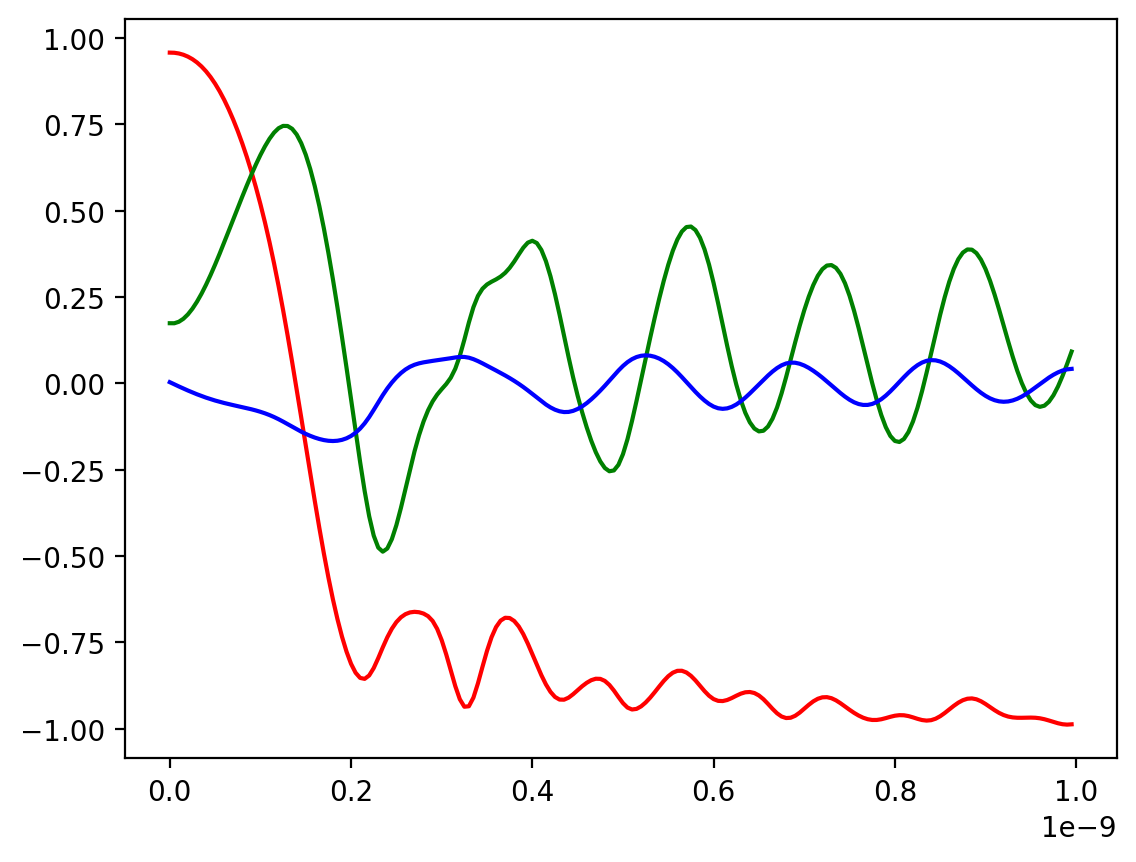

In [12]:
t_array_ns = t_array *  5e-6 / 1e9
plt.plot(t_array_ns[50:] - t_array_ns[50] , Mx_mean_array[50:]/Ms, 'r', label='$M_x$ New Solver')
plt.plot(t_array_ns[50:] - t_array_ns[50], My_mean_array[50:]/Ms, 'g', label='$M_y$ New Solver')
plt.plot(t_array_ns[50:] - t_array_ns[50], Mz_mean_array[50:]/Ms, 'b', label='$M_z$ New Solver')
plt.show()

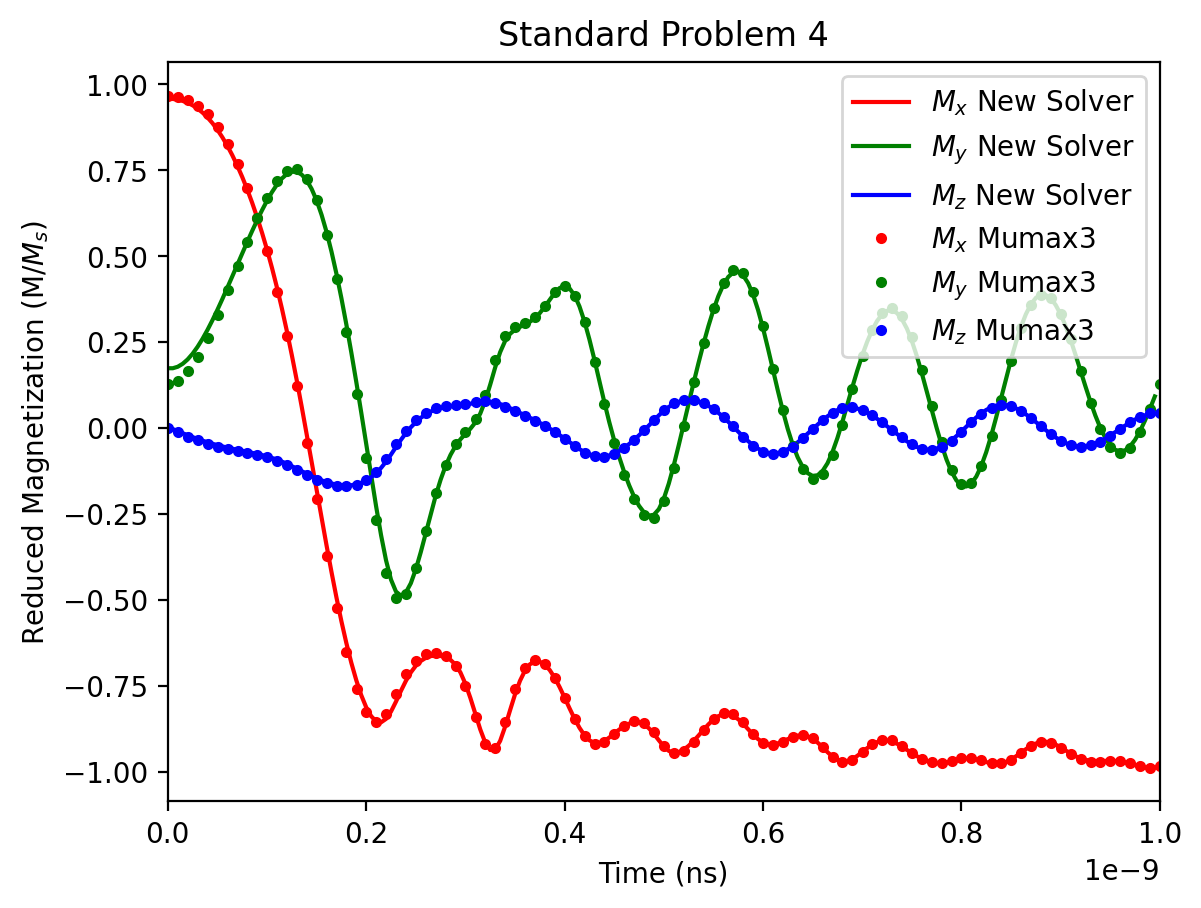

In [13]:
plt.plot(t_array_ns[50:] - t_array_ns[50] , Mx_mean_array[50:]/Ms, 'r', label='$M_x$ New Solver')
plt.plot(t_array_ns[50:] - t_array_ns[50], My_mean_array[50:]/Ms, 'g', label='$M_y$ New Solver')
plt.plot(t_array_ns[50:] - t_array_ns[50], Mz_mean_array[50:]/Ms, 'b', label='$M_z$ New Solver')
plt.plot(mumax_t, mumax_mx, 'r.', label='$M_x$ Mumax3')
plt.plot(mumax_t, mumax_my, 'g.', label='$M_y$ Mumax3')
plt.plot(mumax_t, mumax_mz, 'b.', label='$M_z$ Mumax3')
plt.xlim(0, 1e-9)

plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('Reduced Magnetization (M/$M_s$)')
plt.title('Standard Problem 4')
plt.savefig('std_prob4_mumax3.png', dpi=300)
plt.show()

I downloaded the last submitted results in the standard problem 4 site

https://www.ctcms.nist.gov/~rdm/mumag.org.html

asmus Bjørk, E. B. Poulsen and A. R. Insinga

In [14]:
df_magtense = pd.read_csv("std_problem4_magtense.csv", sep='\t')

In [15]:
magtense_t = df_magtense['%time[s]'].to_numpy()
magtense_mx = df_magtense['m_x'].to_numpy()
magtense_my = df_magtense['m_y'].to_numpy()
magtense_mz = df_magtense['m_z'].to_numpy()

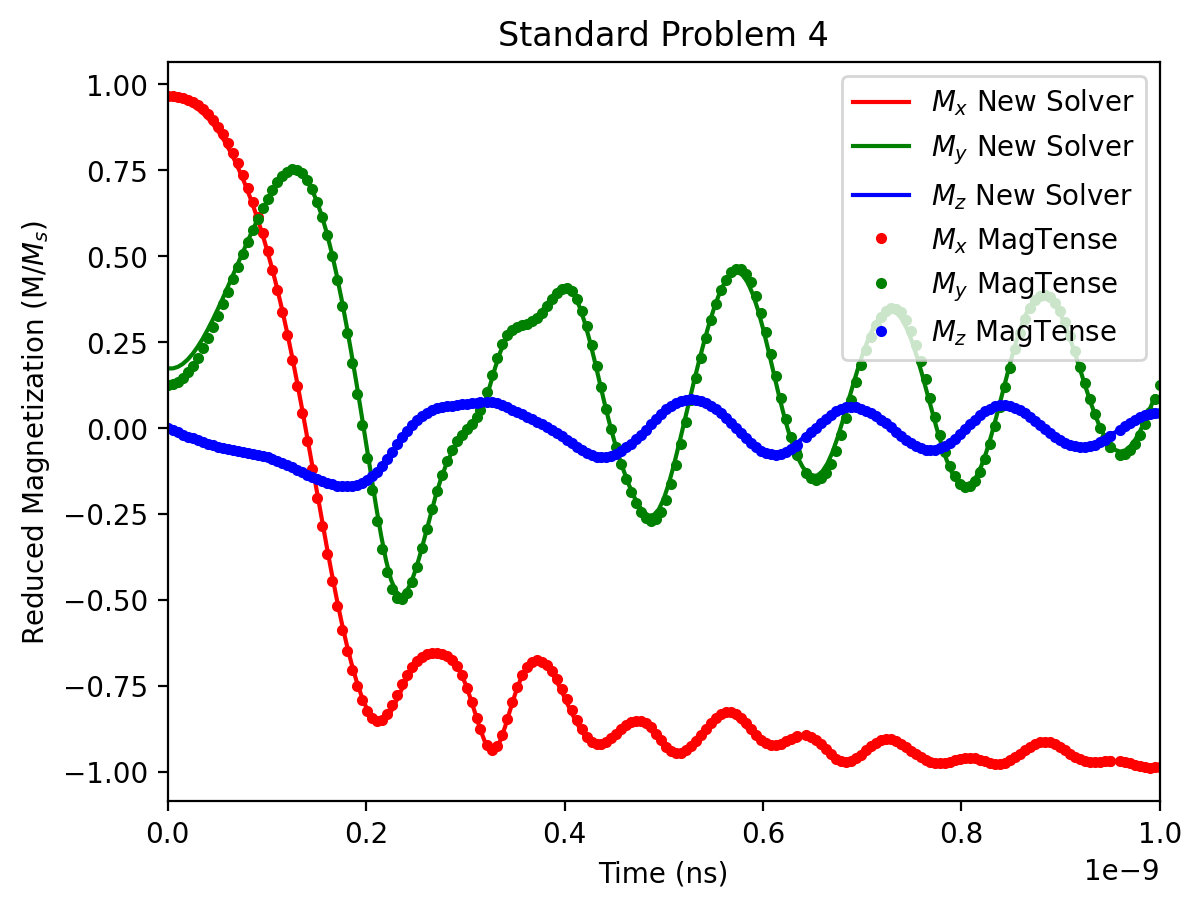

In [16]:
plt.plot(t_array_ns[50:] - t_array_ns[50] , Mx_mean_array[50:]/Ms, 'r', label='$M_x$ New Solver')
plt.plot(t_array_ns[50:] - t_array_ns[50], My_mean_array[50:]/Ms, 'g', label='$M_y$ New Solver')
plt.plot(t_array_ns[50:] - t_array_ns[50], Mz_mean_array[50:]/Ms, 'b', label='$M_z$ New Solver')
plt.plot(magtense_t, magtense_mx, 'r.', label='$M_x$ MagTense')
plt.plot(magtense_t, magtense_my, 'g.', label='$M_y$ MagTense')
plt.plot(magtense_t, magtense_mz, 'b.', label='$M_z$ MagTense')

plt.xlim(0, 1e-9)
plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('Reduced Magnetization (M/$M_s$)')
plt.title('Standard Problem 4')
plt.savefig('std_prob4_magtense.png', dpi=300)
plt.show()